## Model fitting
Week 1 day 2

## Probalistic models

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions
def plot_density_image(x, y, theta, sigma=1, ax=None):
  """ Plots probability distribution of y given x, theta, and sigma

  Args:

    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta (float): Slope parameter
    sigma (float): standard deviation of Gaussian noise

  """

  # plot the probability density of p(y|x,theta)
  if ax is None:
    fig, ax = plt.subplots()

  xmin, xmax = np.floor(np.min(x)), np.ceil(np.max(x))
  ymin, ymax = np.floor(np.min(y)), np.ceil(np.max(y))
  xx = np.linspace(xmin, xmax, 50)
  yy = np.linspace(ymin, ymax, 50)

  surface = np.zeros((len(yy), len(xx)))
  for i, x_i in enumerate(xx):
    surface[:, i] = stats.norm(theta * x_i, sigma).pdf(yy)

  ax.set(xlabel='x', ylabel='y')

  return ax.imshow(surface, origin='lower', aspect='auto', vmin=0, vmax=None,
            cmap=plt.get_cmap('Wistia'),
            extent=[xmin, xmax, ymin, ymax])
# @markdown Execute this cell to generate some simulated data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence


theta = 1.2
n_samples = 30
x = 10 * np.random.rand(n_samples) # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y = theta * x + noise

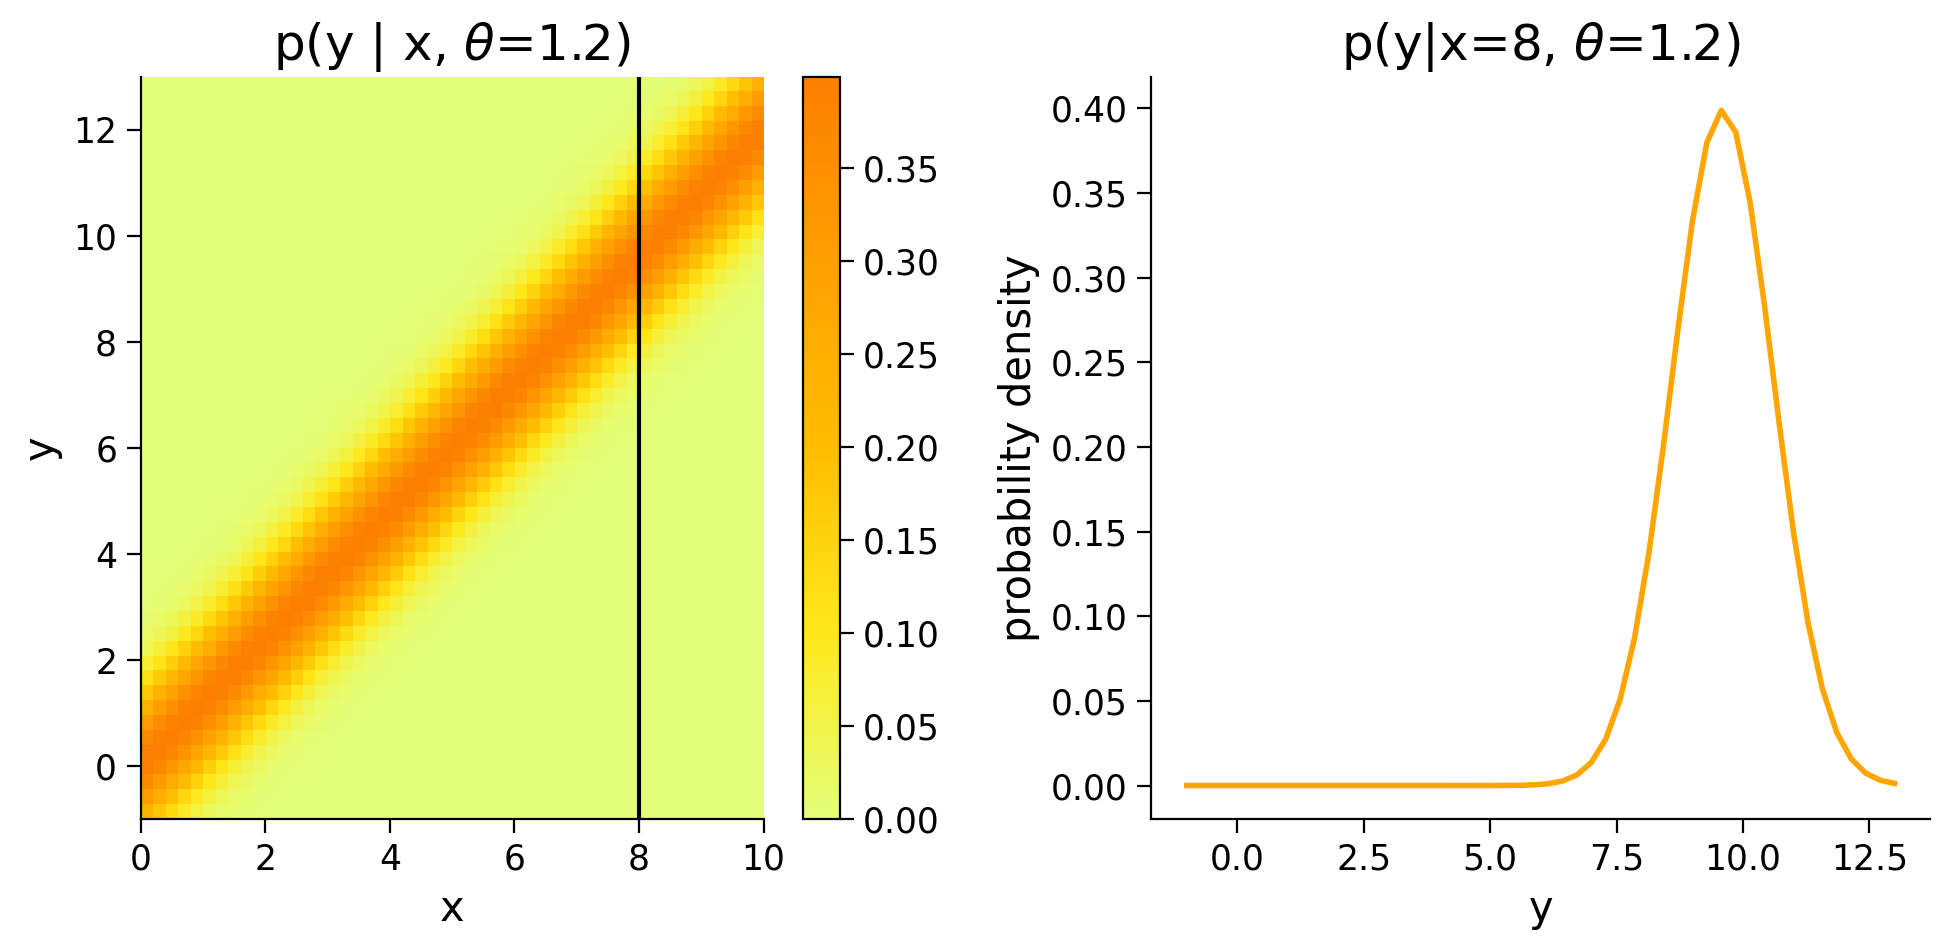

In [19]:
# @markdown Execute this cell to visualize p(y|x, theta=1.2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Invokes helper function to generate density image plots from data and parameters
im = plot_density_image(x, y, 1.2, ax=ax1)
plt.colorbar(im, ax=ax1)
ax1.axvline(8, color='k')
ax1.set(title=r'p(y | x, $\theta$=1.2)')

# Plot pdf for given x
ylim = ax1.get_ylim()
yy = np.linspace(ylim[0], ylim[1], 50)
ax2.plot(yy, stats.norm(theta * 8, 1).pdf(yy), color='orange', linewidth=2)
ax2.set(
    title=r'p(y|x=8, $\theta$=1.2)',
    xlabel='y',
    ylabel='probability density')
plt.show()

In [ ]:
def likelihood(theta_hat, x, y):
  """The likelihood function for a linear model with noise sampled from a
    Gaussian distribution with zero mean and unit variance.

  Args:
    theta_hat (float): An estimate of the slope parameter.
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray: the likelihood values for the theta_hat estimate
  """
  sigma = 1
  ##############################################################################
  ## TODO for students: implement the likelihood function
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: implement the likelihood function")
  ##############################################################################

  # Compute Gaussian likelihood
  pdf = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(y - theta_hat * x)**2 / (2 * sigma**2))


  return pdf


print(likelihood(1.0, x[1], y[1]))

0.4373324038025438


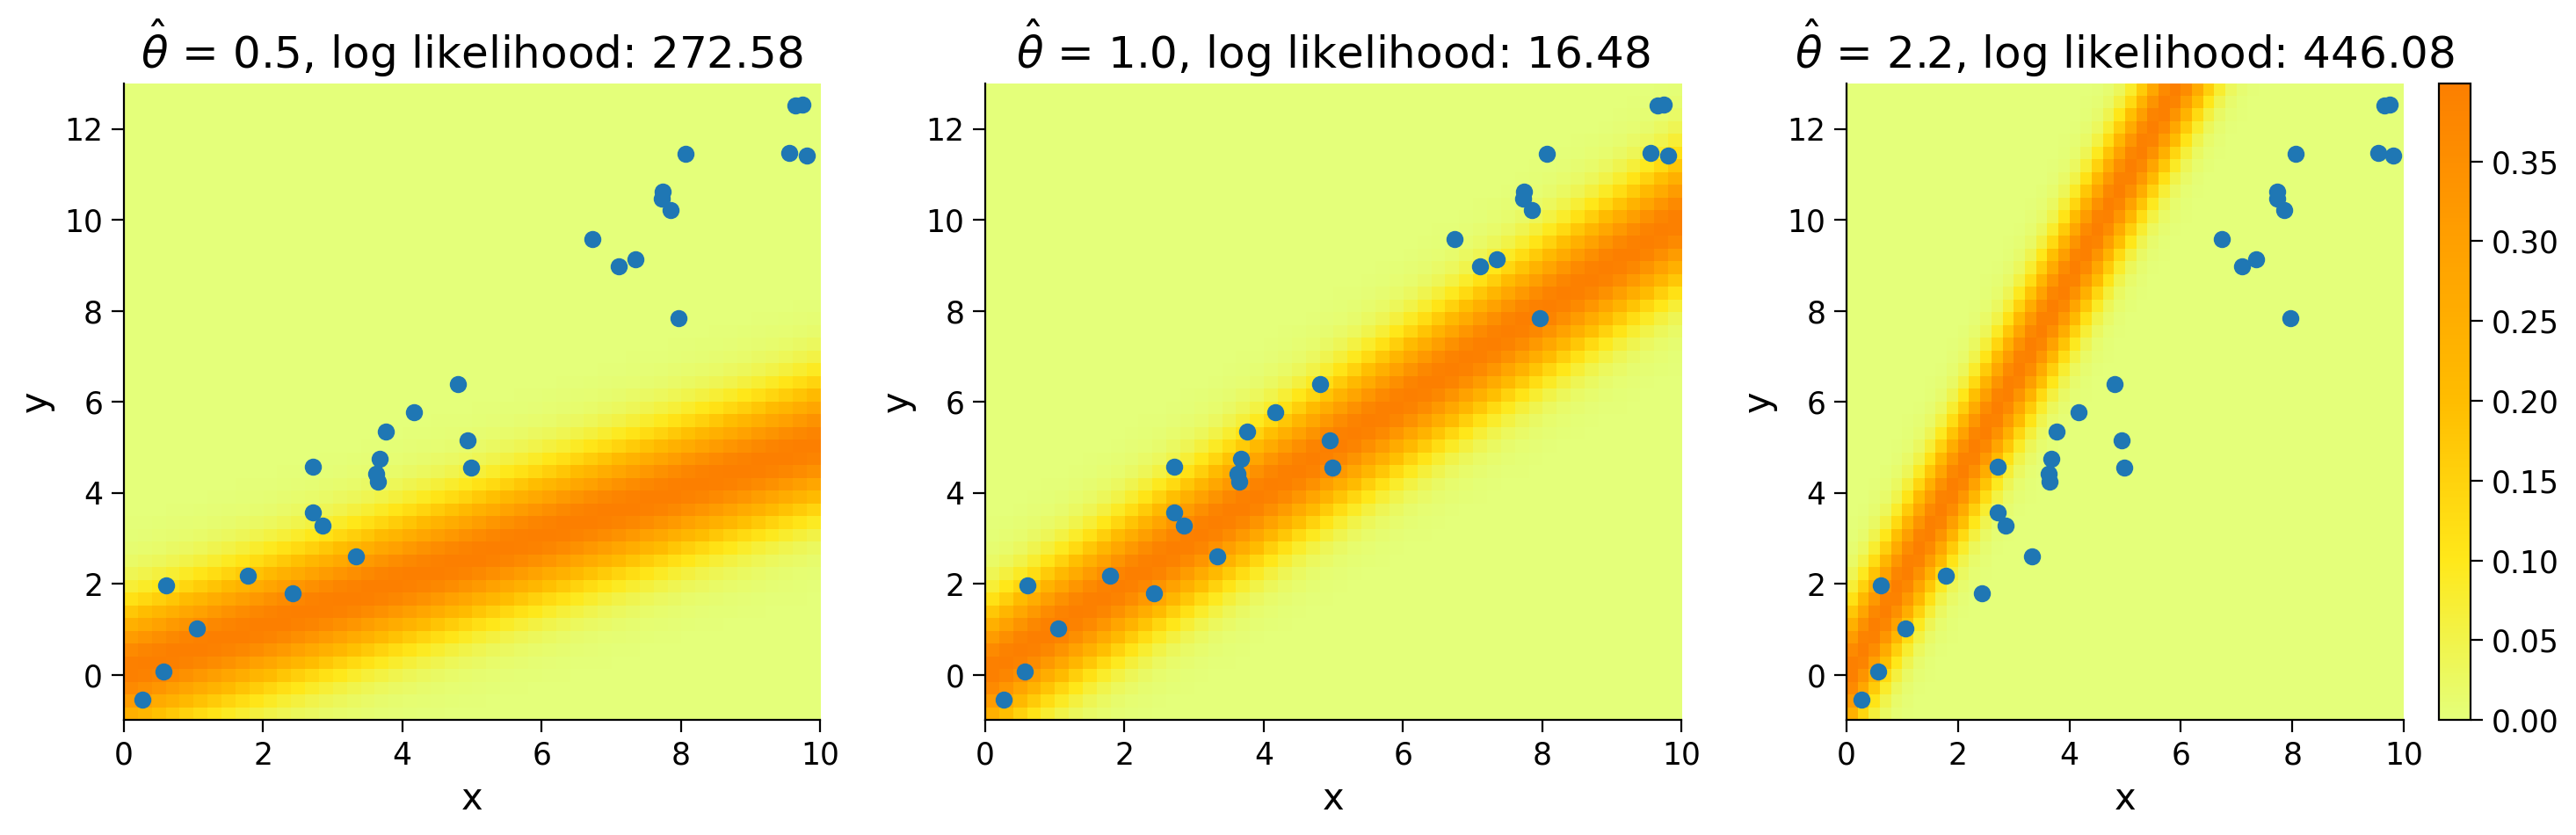

In [27]:
# @markdown Execute this cell to visualize different distribution densities
theta_hats = [0.5, 1.0, 2.2]
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for theta_hat, ax in zip(theta_hats, axes):
  ll = np.sum(np.log(likelihood(theta_hat, x, y)))  # log likelihood
  im = plot_density_image(x, y, theta_hat, ax=ax)
  ax.scatter(x, y)
  ax.set(title=fr'$\hat{{\theta}}$ = {theta_hat}, log likelihood: {ll:.2f}')
plt.colorbar(im, ax=ax)
plt.show()

## Bootstrapping

In [29]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
# @title Plotting Functions

def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim())
  plt.show()

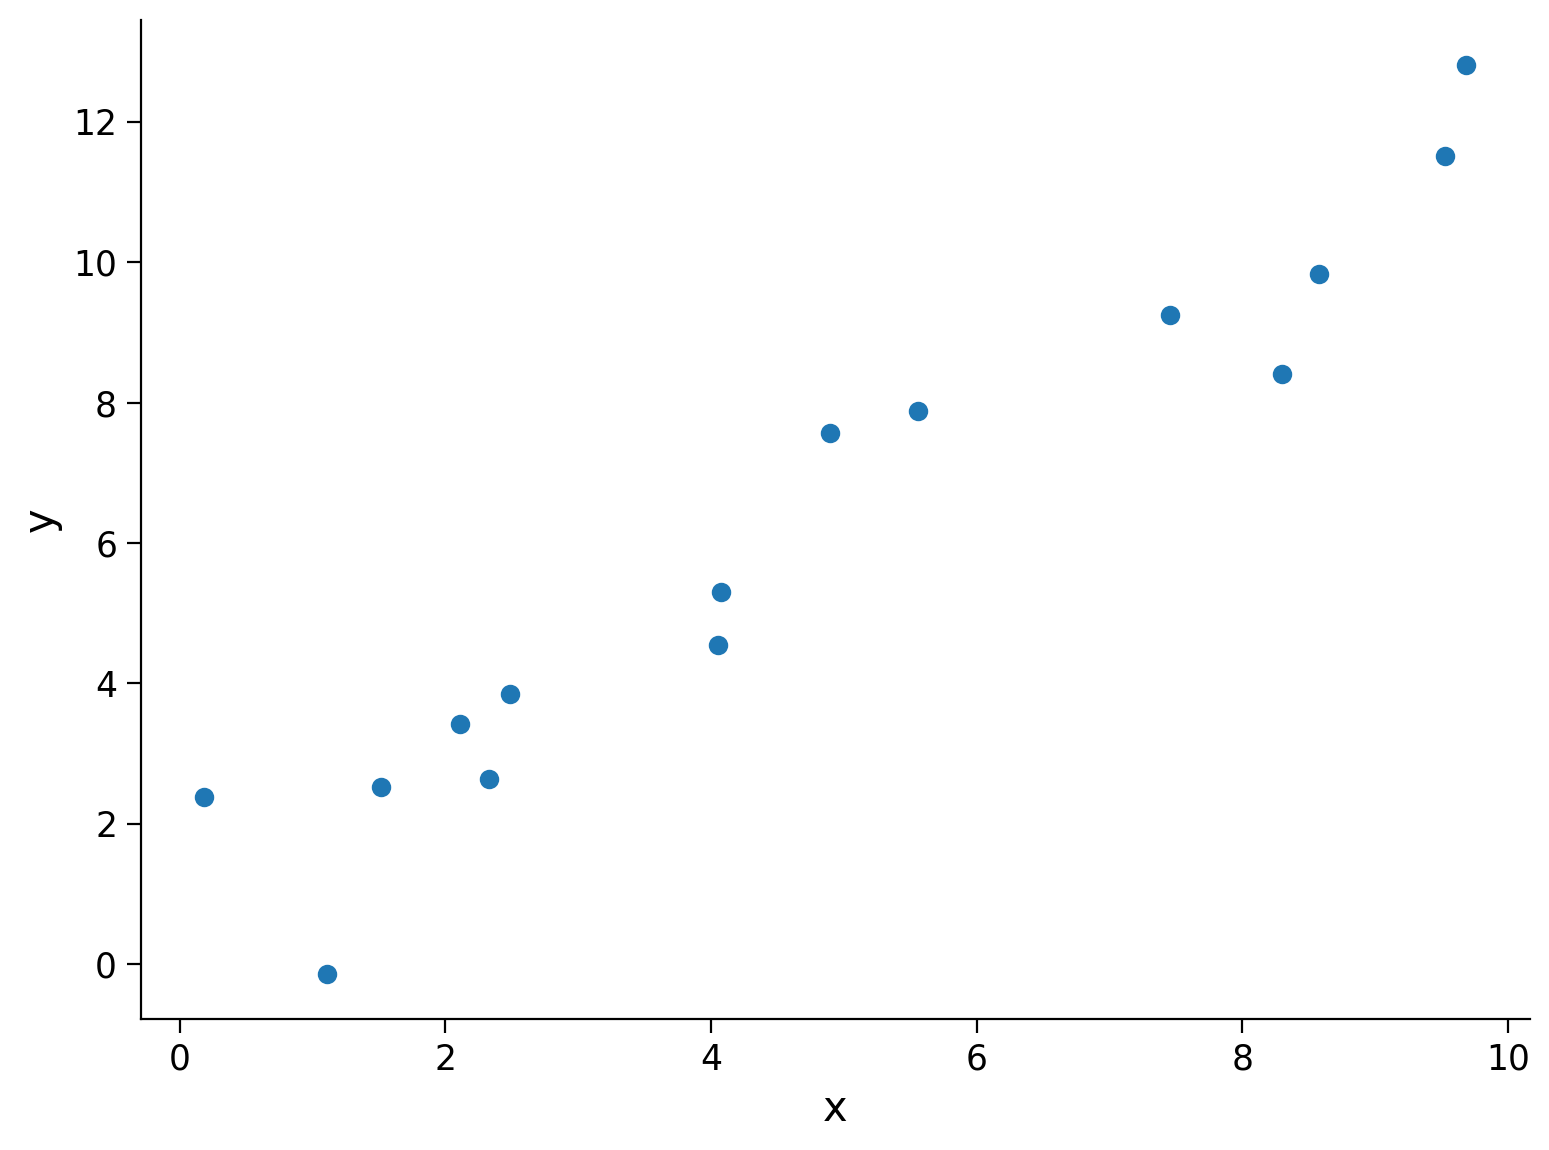

In [30]:
#@title

#@markdown Execute this cell to simulate some data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 15

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

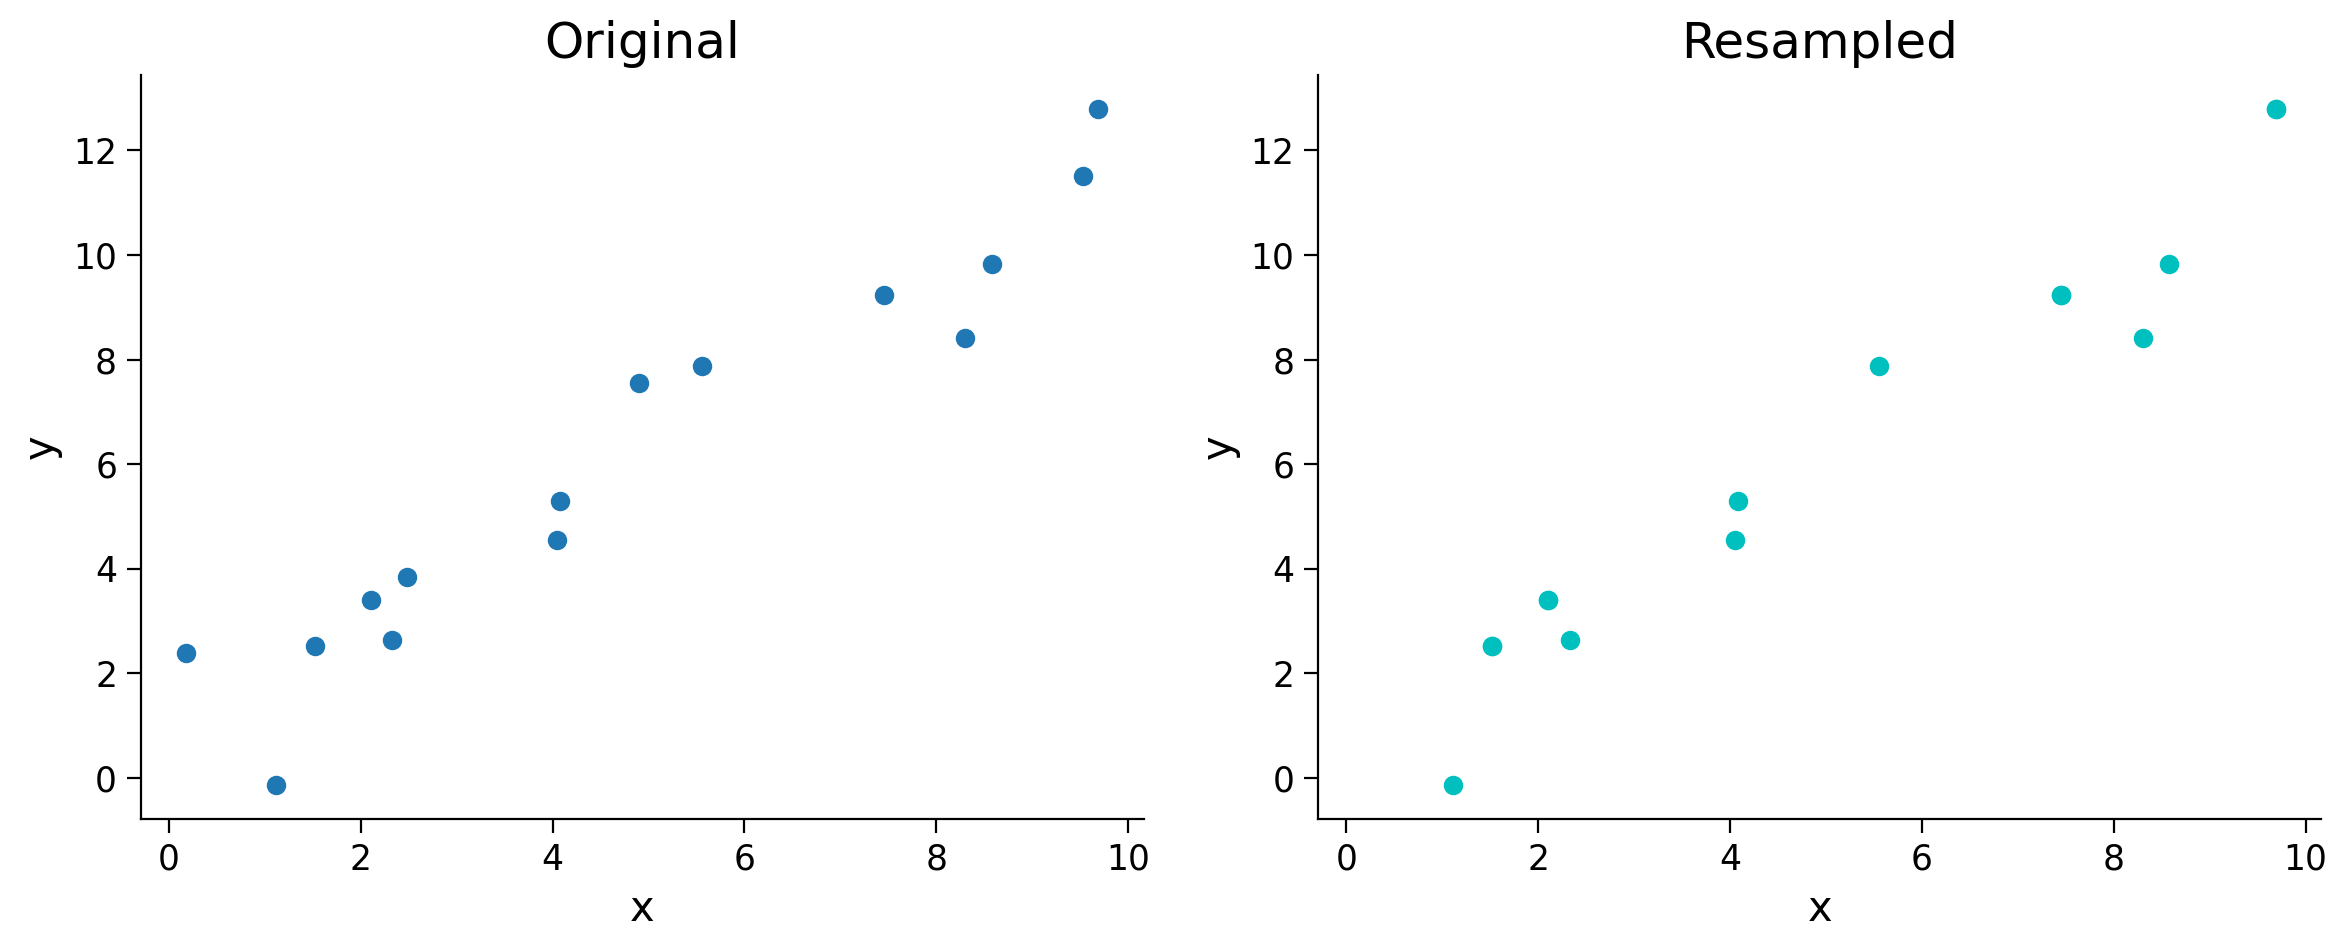

In [45]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """
  #######################################################
  ## TODO for students: resample dataset with replacement
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: resample dataset with replacement")
  #######################################################

  # Get array of indices for resampled points
 
  sample_idx =  np.random.choice(len(x), size=len(x), replace=True)
  

  # Sample from x and y according to sample_idx
  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

x_, y_ = resample_with_replacement(x, y)

plot_original_and_resample(x, y, x_, y_)

In [46]:
# @markdown Execute this cell for helper function `solve_normal_eqn`
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    thata_hat (float): An estimate of the slope parameter.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """
  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat

In [47]:
def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute

  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  ##############################################################################
  ## TODO for students: implement bootstrap estimation
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: implement bootstrap estimation")
  ##############################################################################

  # Loop over number of estimates
  for i in range(n):
    sample_idx =  np.random.choice(len(x), size=len(x), replace=True)
  

  # Sample from x and y according to sample_idx
    x_ = x[sample_idx]
    y_ = y[sample_idx]
    # Resample x and y
    

    # Compute theta_hat for this sample
    theta_hats[i] = solve_normal_eqn(x_, y_)

  return theta_hats


# Set random seed
np.random.seed(123)

# Get bootstrap estimates
theta_hats = bootstrap_estimates(x, y, n=2000)
print(theta_hats[0:5])

[1.27550888 1.17317819 1.18198819 1.25329255 1.20714664]


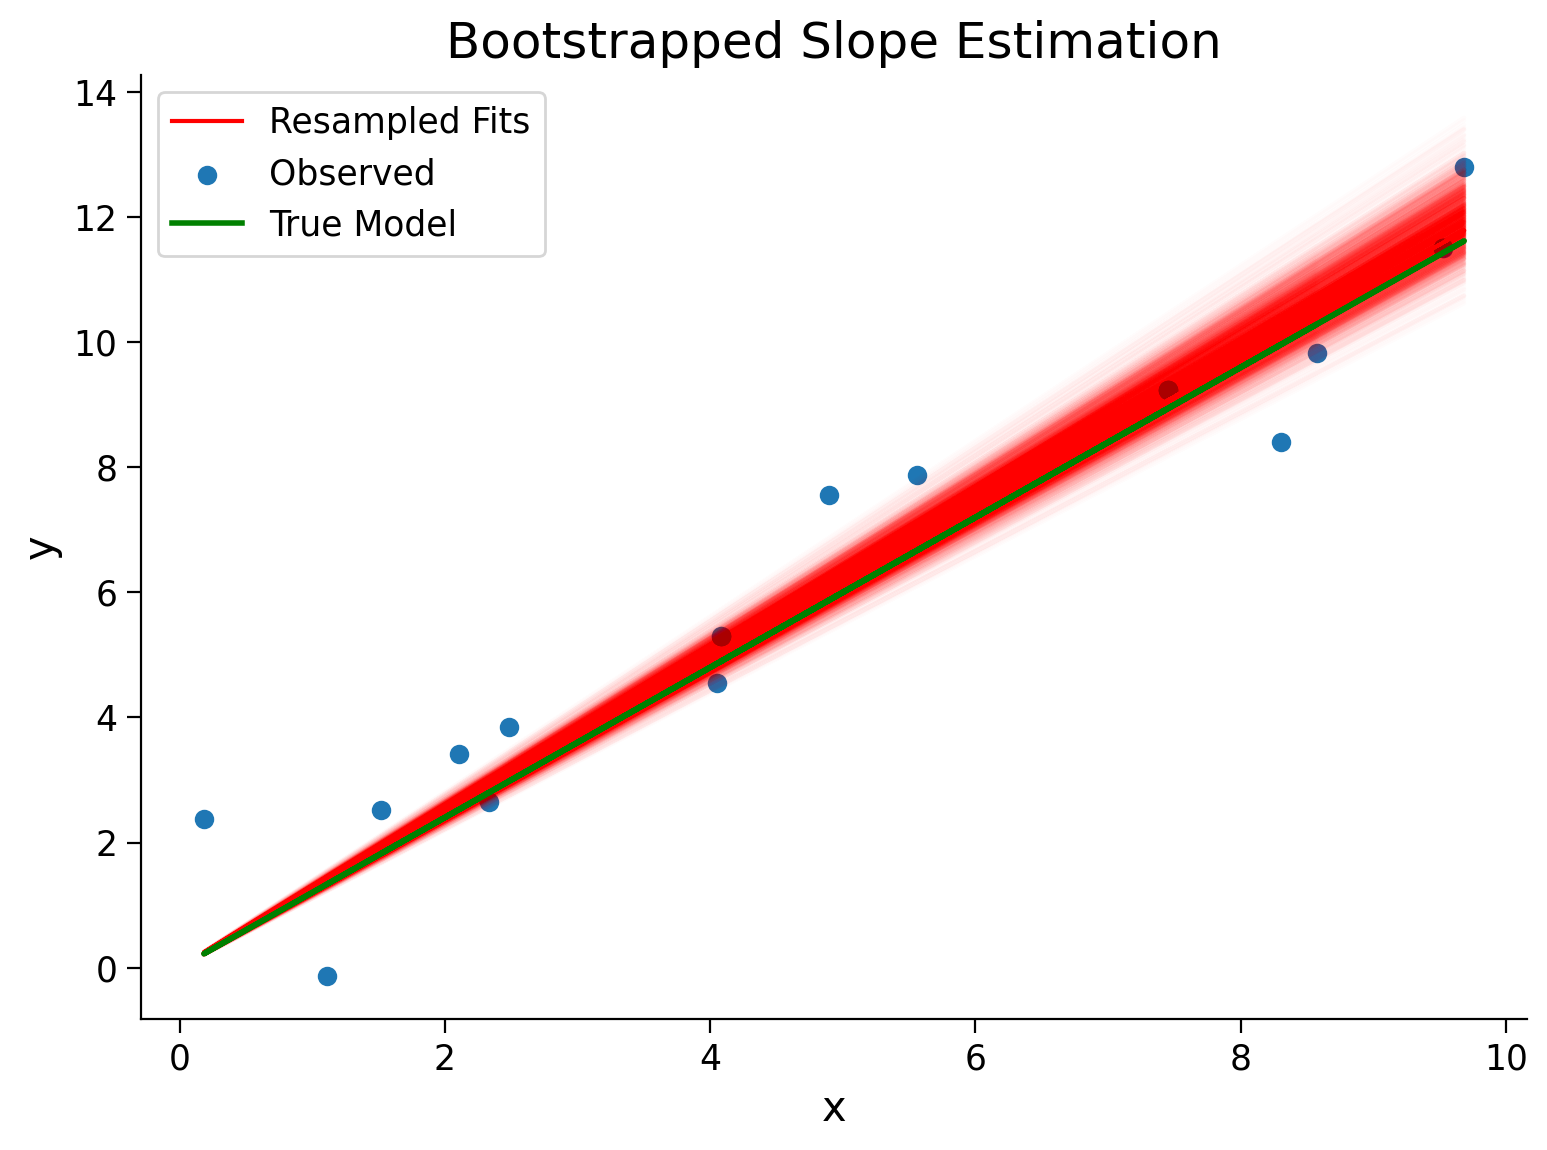

In [48]:
# @markdown Execute this cell to visualize all potential models

fig, ax = plt.subplots()

# For each theta_hat, plot model
theta_hats = bootstrap_estimates(x, y, n=2000)
for i, theta_hat in enumerate(theta_hats):
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

# Plot observed data
ax.scatter(x, y, label='Observed')

# Plot true fit data
y_true = theta * x
ax.plot(x, y_true, 'g', linewidth=2, label='True Model')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)

# Change legend line alpha property
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend()
plt.show()

mean = 1.24, std = 0.05


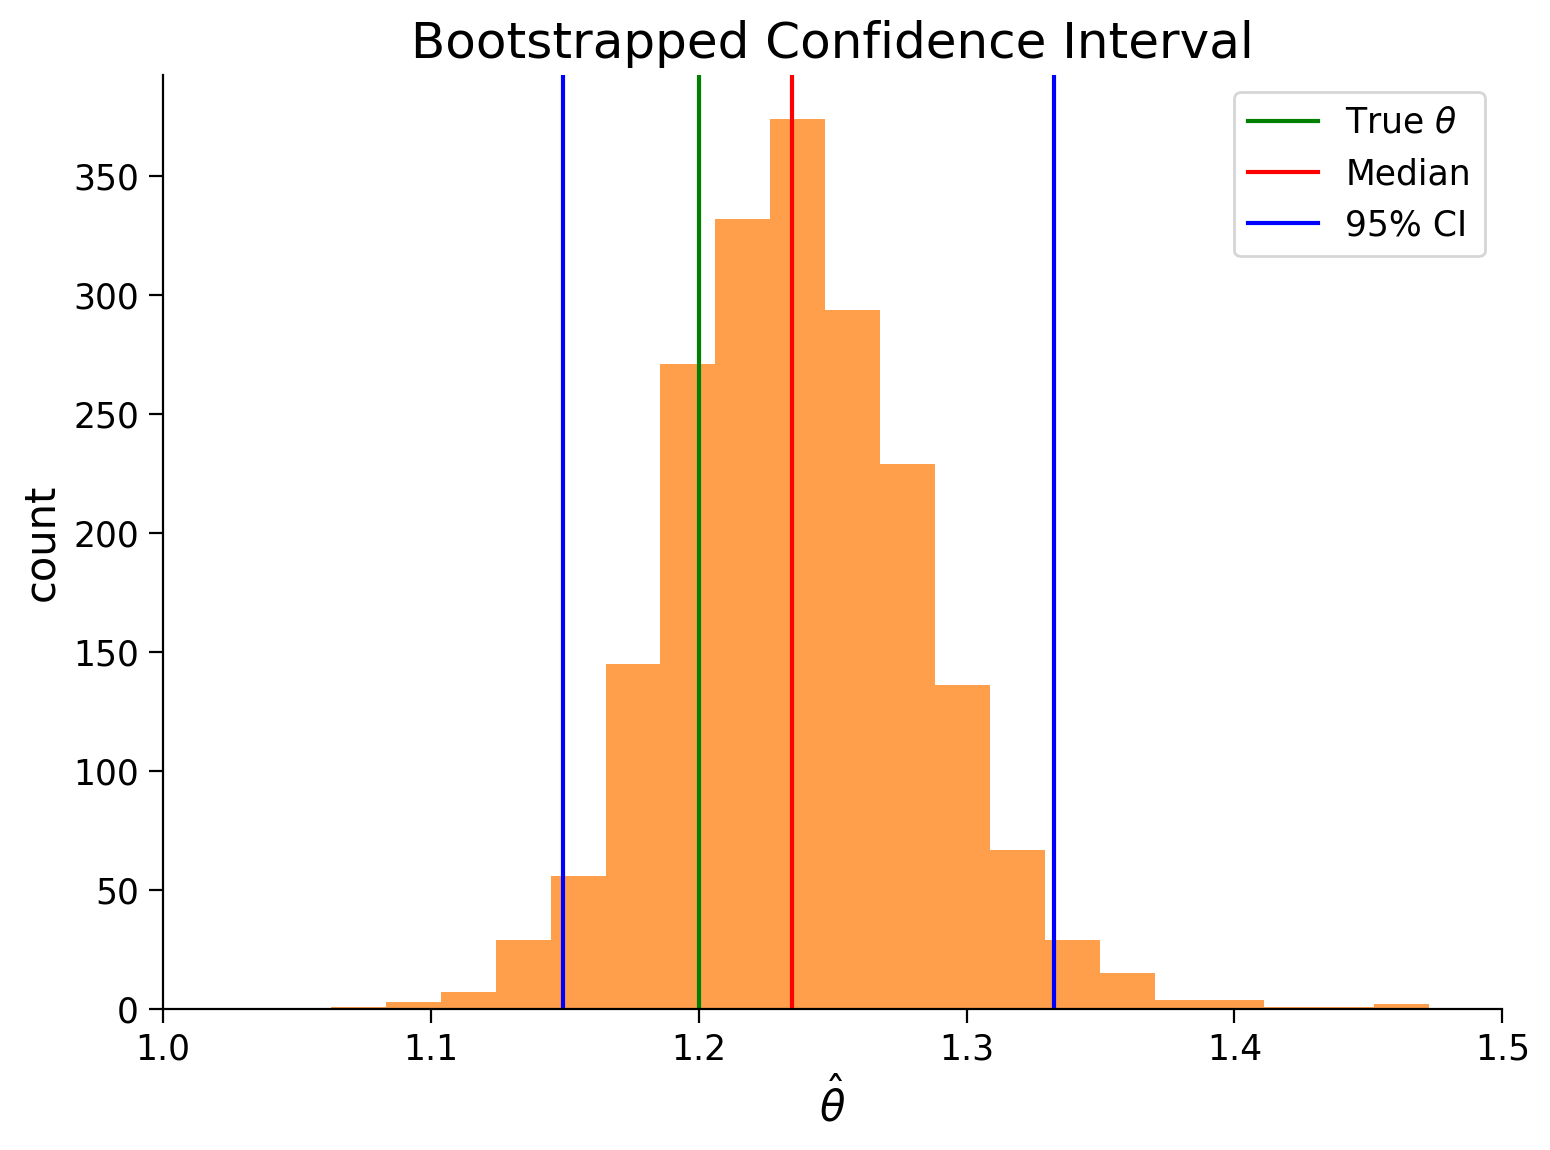

In [49]:
# @markdown Execute this cell to plot bootstrapped CI

theta_hats = bootstrap_estimates(x, y, n=2000)
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, bins=20, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='g', label=r'True $\theta$')
ax.axvline(np.percentile(theta_hats, 50), color='r', label='Median')
ax.axvline(np.percentile(theta_hats, 2.5), color='b', label='95% CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='b')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{{\theta}}$',
    ylabel='count',
    xlim=[1.0, 1.5]
)
plt.show()